In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

import cv2
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
from torchvision import transforms

import torchlens

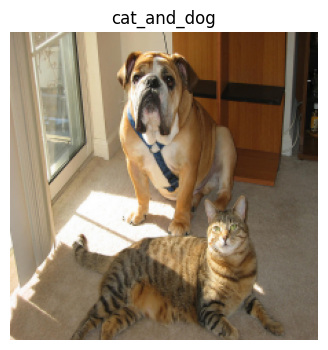

In [2]:
# Load image
cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
# Display the image using matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cat_and_dog)
plt.axis('off')  # Hide axes
plt.title('cat_and_dog')
plt.show()

In [3]:
# Convert to float32 first for matplotlib compatibility, then convert back to float16 for model
cat_and_dog = np.float32(cat_and_dog) / 255  # Keep float32 for model
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [4]:
# model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
# model = model.half()  # Convert model to half precision (float16)

In [5]:
# Check the model's parameter precision
print(f"Model parameter dtype: {next(model.parameters()).dtype}")
print(f"Input tensor dtype: {input_tensor.dtype}")

Model parameter dtype: torch.float32
Input tensor dtype: torch.float32


In [6]:
torchlens.show_model_graph(model, input_tensor, vis_opt='unrolled', vis_nesting_depth=2, vis_direction='leftright', save_only=True)

In [7]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [8]:
model.to(device)
input_tensor = input_tensor.to(device)

In [9]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
target_layers = [model.features[-1]]  # For AlexNet, use the last layer of features

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(246)] # 281 is the ImageNet index of 'tabby, tabby cat', 246 is 'boxer'

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
# Use float32 version for visualization to avoid matplotlib issues
visualization = show_cam_on_image(cat_and_dog, grayscale_cam, use_rgb=True)

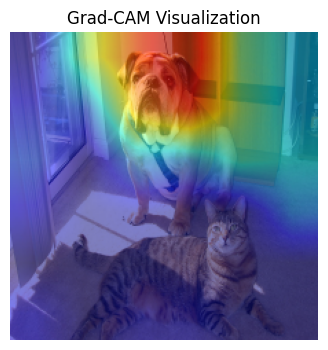

In [11]:
# Display the CAM visualization
plt.figure(figsize=(5, 4))
plt.imshow(visualization)
plt.axis('off')  # Hide axes
plt.title('Grad-CAM Visualization')
plt.show()

# FP32 vs FP16 Precision Comparison

下面我们将比较FP32和FP16精度下的CAM输出差异和推理准确度变化。

In [12]:
# 工具函数定义
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import time

def calculate_cam_difference(cam_fp32, cam_fp16):
    """计算两个CAM输出之间的差异"""
    # 计算均方误差
    mse = np.mean((cam_fp32 - cam_fp16) ** 2)
    
    # 计算平均绝对误差
    mae = np.mean(np.abs(cam_fp32 - cam_fp16))
    
    # 计算最大绝对误差
    max_ae = np.max(np.abs(cam_fp32 - cam_fp16))
    
    # 计算相关系数
    correlation = np.corrcoef(cam_fp32.flatten(), cam_fp16.flatten())[0, 1]
    
    return {
        'mse': mse,
        'mae': mae,
        'max_ae': max_ae,
        'correlation': correlation
    }

def get_model_predictions(model, input_tensor, top_k=5):
    """获取模型预测结果"""
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs[0], dim=0)
        top_probs, top_indices = torch.topk(probabilities, top_k)
    
    return top_probs.cpu().numpy(), top_indices.cpu().numpy()

def compare_predictions(pred_fp32, pred_fp16, indices_fp32, indices_fp16):
    """比较两个精度下的预测结果"""
    # 计算top-1准确度
    top1_match = indices_fp32[0] == indices_fp16[0]
    
    # 计算top-5准确度匹配
    top5_intersection = len(set(indices_fp32) & set(indices_fp16))
    
    # 计算概率差异
    prob_diff = np.mean(np.abs(pred_fp32 - pred_fp16))
    
    return {
        'top1_match': top1_match,
        'top5_intersection': top5_intersection,
        'prob_diff': prob_diff
    }

print("工具函数定义完成")

工具函数定义完成


In [13]:
# 准备测试图片
test_images_urls = [
    "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png",  # cat and dog
    "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png",   # cat and dog
    "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dogs.png",   # dogs
]

test_images = []
test_names = ["cat_and_dog", "cat_and_dog", "dog"]

for i, url in enumerate(test_images_urls):
    try:
        image = np.array(Image.open(requests.get(url, stream=True).raw))
        image = np.float32(image) / 255
        test_images.append(image)
        print(f"成功加载图片: {test_names[i]} - 形状: {image.shape}")
    except Exception as e:
        print(f"加载图片 {test_names[i]} 失败: {e}")

print(f"\n总共加载了 {len(test_images)} 张测试图片")

成功加载图片: cat_and_dog - 形状: (224, 224, 3)
成功加载图片: cat_and_dog - 形状: (224, 224, 3)
成功加载图片: dog - 形状: (342, 347, 3)

总共加载了 3 张测试图片


In [14]:
# 创建FP32和FP16模型
model_fp32 = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)
model_fp16 = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device).half()

# 设置为评估模式但启用梯度计算
model_fp32.eval()
model_fp16.eval()

# 检查模型精度
print(f"FP32 模型参数类型: {next(model_fp32.parameters()).dtype}")
print(f"FP16 模型参数类型: {next(model_fp16.parameters()).dtype}")

# 准备CAM对象
target_layers_fp32 = [model_fp32.features[-1]]
target_layers_fp16 = [model_fp16.features[-1]]

cam_fp32 = GradCAM(model=model_fp32, target_layers=target_layers_fp32)
cam_fp16 = GradCAM(model=model_fp16, target_layers=target_layers_fp16)

print("模型和CAM对象准备完成")

FP32 模型参数类型: torch.float32
FP16 模型参数类型: torch.float16
模型和CAM对象准备完成


In [15]:
# 执行精度比较测试
results = []

# 测试不同的目标类别
test_targets = [246, 281, 246]  # boxer, tabby cat, boxer
target_names = ["boxer", "tabby_cat", "boxer"]

for img_idx, (test_image, img_name) in enumerate(zip(test_images, test_names)):
    print(f"\n=== 测试图片: {img_name} ===")
    
    # 预处理图片
    input_tensor_fp32 = preprocess_image(test_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
    input_tensor_fp16 = input_tensor_fp32.half()
    
    # 确保输入tensor需要梯度
    input_tensor_fp32.requires_grad_(True)
    input_tensor_fp16.requires_grad_(True)
    
    for target_idx, (target_class, target_name) in enumerate(zip(test_targets, target_names)):
        print(f"\n  目标类别: {target_name} (class {target_class})")
        
        targets = [ClassifierOutputTarget(target_class)]
        
        # 测量推理时间和生成CAM
        # FP32
        start_time = time.time()
        grayscale_cam_fp32 = cam_fp32(input_tensor=input_tensor_fp32, targets=targets)
        with torch.no_grad():
            pred_probs_fp32, pred_indices_fp32 = get_model_predictions(model_fp32, input_tensor_fp32)
        fp32_time = time.time() - start_time
        
        # FP16
        start_time = time.time()
        grayscale_cam_fp16 = cam_fp16(input_tensor=input_tensor_fp16, targets=targets)
        with torch.no_grad():
            pred_probs_fp16, pred_indices_fp16 = get_model_predictions(model_fp16, input_tensor_fp16)
        fp16_time = time.time() - start_time
        
        # 计算差异
        cam_diff = calculate_cam_difference(grayscale_cam_fp32[0], grayscale_cam_fp16[0])
        pred_diff = compare_predictions(pred_probs_fp32, pred_probs_fp16, pred_indices_fp32, pred_indices_fp16)
        
        # 存储结果
        result = {
            'image': img_name,
            'target': target_name,
            'target_class': target_class,
            'cam_mse': cam_diff['mse'],
            'cam_mae': cam_diff['mae'],
            'cam_max_ae': cam_diff['max_ae'],
            'cam_correlation': cam_diff['correlation'],
            'top1_match': pred_diff['top1_match'],
            'top5_intersection': pred_diff['top5_intersection'],
            'prob_diff': pred_diff['prob_diff'],
            'fp32_time': fp32_time,
            'fp16_time': fp16_time,
            'speedup': fp32_time / fp16_time if fp16_time > 0 else 0
        }
        results.append(result)
        
        # 打印当前结果
        print(f"    CAM MSE: {cam_diff['mse']:.6f}")
        print(f"    CAM相关系数: {cam_diff['correlation']:.6f}")
        print(f"    Top-1匹配: {pred_diff['top1_match']}")
        print(f"    Top-5交集: {pred_diff['top5_intersection']}/5")
        print(f"    FP32时间: {fp32_time:.4f}s, FP16时间: {fp16_time:.4f}s, 加速比: {fp32_time/fp16_time:.2f}x")


=== 测试图片: cat_and_dog ===

  目标类别: boxer (class 246)
    CAM MSE: 0.000000
    CAM相关系数: 0.999999
    Top-1匹配: True
    Top-5交集: 5/5
    FP32时间: 0.0236s, FP16时间: 0.1008s, 加速比: 0.23x

  目标类别: tabby_cat (class 281)
    CAM MSE: 0.000000
    CAM相关系数: 0.999999
    Top-1匹配: True
    Top-5交集: 5/5
    FP32时间: 0.0029s, FP16时间: 0.0021s, 加速比: 1.37x

  目标类别: boxer (class 246)
    CAM MSE: 0.000000
    CAM相关系数: 0.999999
    Top-1匹配: True
    Top-5交集: 5/5
    FP32时间: 0.0028s, FP16时间: 0.0020s, 加速比: 1.36x

=== 测试图片: cat_and_dog ===

  目标类别: boxer (class 246)
    CAM MSE: 0.000000
    CAM相关系数: 0.999999
    Top-1匹配: True
    Top-5交集: 5/5
    FP32时间: 0.0027s, FP16时间: 0.0020s, 加速比: 1.35x

  目标类别: tabby_cat (class 281)
    CAM MSE: 0.000000
    CAM相关系数: 0.999999
    Top-1匹配: True
    Top-5交集: 5/5
    FP32时间: 0.0026s, FP16时间: 0.0020s, 加速比: 1.32x

  目标类别: boxer (class 246)
    CAM MSE: 0.000000
    CAM相关系数: 0.999999
    Top-1匹配: True
    Top-5交集: 5/5
    FP32时间: 0.0026s, FP16时间: 0.0020s, 加速比: 1.31x

=== 测试图

In [16]:
# 统计分析结果
import pandas as pd

# 转换为DataFrame便于分析
df_results = pd.DataFrame(results)

print("=== 整体统计结果 ===")
print(f"测试用例总数: {len(results)}")
print(f"\nCAM差异统计:")
print(f"  平均MSE: {df_results['cam_mse'].mean():.8f}")
print(f"  平均MAE: {df_results['cam_mae'].mean():.8f}")
print(f"  平均相关系数: {df_results['cam_correlation'].mean():.6f}")
print(f"  最大绝对误差均值: {df_results['cam_max_ae'].mean():.6f}")

print(f"\n预测准确度:")
print(f"  Top-1匹配率: {df_results['top1_match'].mean():.2%}")
print(f"  平均Top-5交集: {df_results['top5_intersection'].mean():.2f}/5")
print(f"  平均概率差异: {df_results['prob_diff'].mean():.6f}")

print(f"\n性能提升:")
print(f"  平均FP32时间: {df_results['fp32_time'].mean():.4f}s")
print(f"  平均FP16时间: {df_results['fp16_time'].mean():.4f}s")
print(f"  平均加速比: {df_results['speedup'].mean():.2f}x")

# 显示详细结果表格
print(f"\n=== 详细结果表格 ===")
display_df = df_results[['image', 'target', 'cam_mse', 'cam_correlation', 'top1_match', 'top5_intersection', 'speedup']].round(6)
print(display_df.to_string(index=False))

=== 整体统计结果 ===
测试用例总数: 9

CAM差异统计:
  平均MSE: 0.00000017
  平均MAE: 0.00027199
  平均相关系数: 0.999999
  最大绝对误差均值: 0.001785

预测准确度:
  Top-1匹配率: 100.00%
  平均Top-5交集: 5.00/5
  平均概率差异: 0.000175

性能提升:
  平均FP32时间: 0.0059s
  平均FP16时间: 0.0144s
  平均加速比: 1.13x

=== 详细结果表格 ===
      image    target  cam_mse  cam_correlation  top1_match  top5_intersection  speedup
cat_and_dog     boxer      0.0         0.999999        True                  5 0.234077
cat_and_dog tabby_cat      0.0         0.999999        True                  5 1.372435
cat_and_dog     boxer      0.0         0.999999        True                  5 1.363872
cat_and_dog     boxer      0.0         0.999999        True                  5 1.353557
cat_and_dog tabby_cat      0.0         0.999999        True                  5 1.319321
cat_and_dog     boxer      0.0         0.999999        True                  5 1.308758
        dog     boxer      0.0         0.999998        True                  5 0.682315
        dog tabby_cat      0.0      

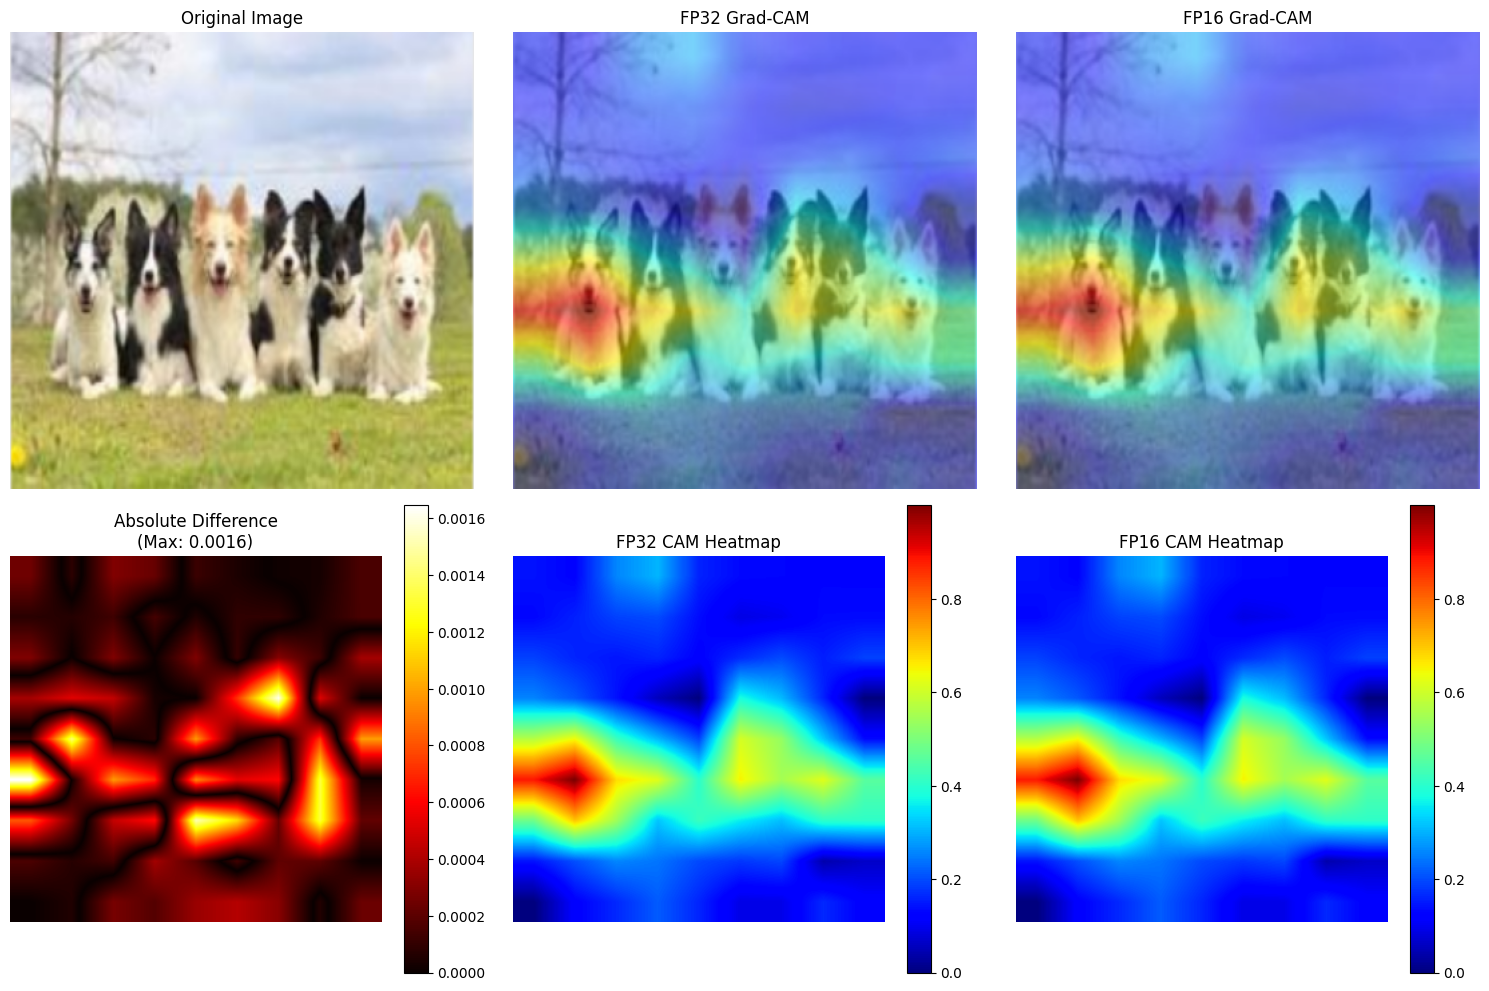


=== CAM差异详细统计 ===
mse: 0.00000014
mae: 0.00025807
max_ae: 0.00164580
correlation: 0.99999825


In [ ]:
# 可视化比较
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 选择第一张图片进行可视化比较
test_image = test_images[0]  # cat_and_dog
input_tensor_fp32 = preprocess_image(test_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
input_tensor_fp16 = input_tensor_fp32.half()

# 确保输入tensor需要梯度
input_tensor_fp32.requires_grad_(True)
input_tensor_fp16.requires_grad_(True)

targets = [ClassifierOutputTarget(246)]  # 246: boxer    281: tabby cat

# 生成CAM
grayscale_cam_fp32 = cam_fp32(input_tensor=input_tensor_fp32, targets=targets)[0]
grayscale_cam_fp16 = cam_fp16(input_tensor=input_tensor_fp16, targets=targets)[0]

# 生成可视化
visualization_fp32 = show_cam_on_image(test_image, grayscale_cam_fp32, use_rgb=True)
visualization_fp16 = show_cam_on_image(test_image, grayscale_cam_fp16, use_rgb=True)

# 计算差异图
cam_diff_abs = np.abs(grayscale_cam_fp32 - grayscale_cam_fp16)

# 显示原图
axes[0, 0].imshow(test_image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# 显示FP32 CAM
axes[0, 1].imshow(visualization_fp32)
axes[0, 1].set_title('FP32 Grad-CAM')
axes[0, 1].axis('off')

# 显示FP16 CAM
axes[0, 2].imshow(visualization_fp16)
axes[0, 2].set_title('FP16 Grad-CAM')
axes[0, 2].axis('off')

# 显示CAM差异热图
im1 = axes[1, 0].imshow(cam_diff_abs, cmap='hot')
axes[1, 0].set_title(f'Absolute Difference\n(Max: {cam_diff_abs.max():.4f})')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0])

# 显示FP32 CAM热图
im2 = axes[1, 1].imshow(grayscale_cam_fp32, cmap='jet')
axes[1, 1].set_title('FP32 CAM Heatmap')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1])

# 显示FP16 CAM热图
im3 = axes[1, 2].imshow(grayscale_cam_fp16, cmap='jet')
axes[1, 2].set_title('FP16 CAM Heatmap')
axes[1, 2].axis('off')
plt.colorbar(im3, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# 打印详细的数值比较
cam_diff_stats = calculate_cam_difference(grayscale_cam_fp32, grayscale_cam_fp16)
print("\n=== CAM差异详细统计 ===")
for key, value in cam_diff_stats.items():
    print(f"{key}: {value:.8f}")

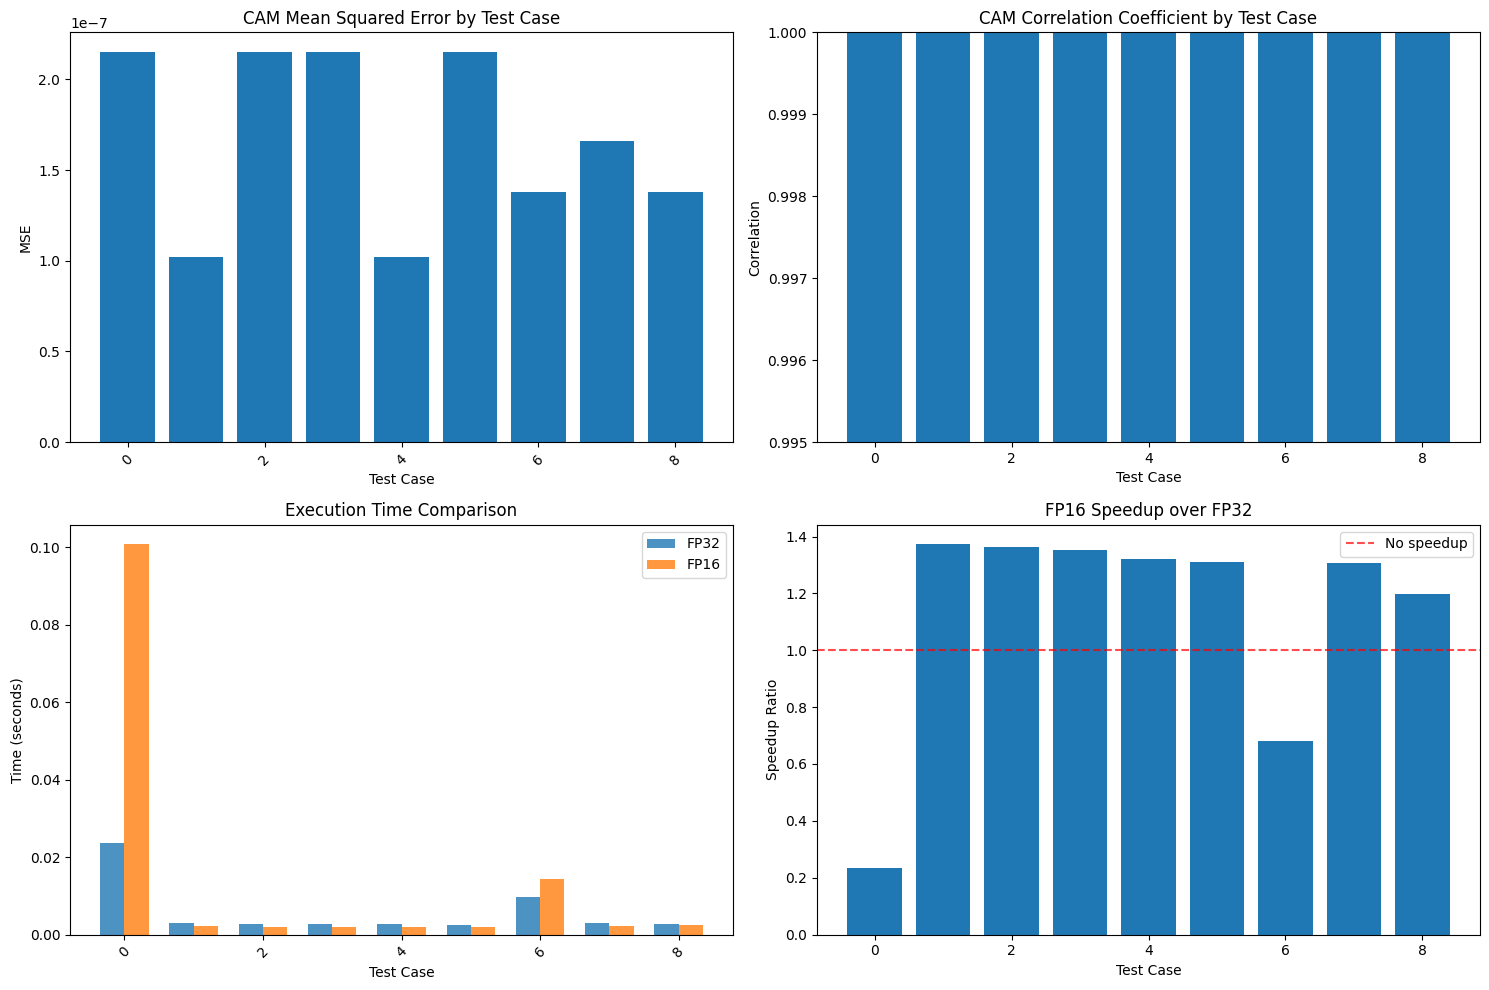


FP32 vs FP16 精度比较总结报告

🎯 CAM质量分析:
   平均相关系数: 0.999999 (越接近1越好)
   平均MSE: 0.00000017 (越小越好)
   ✅ CAM质量: 优秀 - FP16与FP32几乎完全一致

🎯 预测准确度分析:
   Top-1匹配率: 100.0%
   平均Top-5交集: 5.0/5
   ✅ 预测准确度: 优秀 - FP16预测与FP32高度一致

🎯 性能提升分析:
   平均加速比: 1.13x
   ✅ 性能提升: 中等 - FP16有一定加速效果

📝 建议:
   推荐使用FP16进行CAM计算，可以在保持质量的同时获得性能提升


In [18]:
# 生成性能分析图表
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. CAM MSE分布
ax1.bar(range(len(results)), [r['cam_mse'] for r in results])
ax1.set_title('CAM Mean Squared Error by Test Case')
ax1.set_xlabel('Test Case')
ax1.set_ylabel('MSE')
ax1.tick_params(axis='x', rotation=45)

# 2. 相关系数分布
ax2.bar(range(len(results)), [r['cam_correlation'] for r in results])
ax2.set_title('CAM Correlation Coefficient by Test Case')
ax2.set_xlabel('Test Case')
ax2.set_ylabel('Correlation')
ax2.set_ylim([0.995, 1.0])  # 放大显示微小差异

# 3. 执行时间比较
test_cases = [f"{r['image']}_{r['target']}" for r in results]
x_pos = range(len(results))
width = 0.35

fp32_times = [r['fp32_time'] for r in results]
fp16_times = [r['fp16_time'] for r in results]

ax3.bar([x - width/2 for x in x_pos], fp32_times, width, label='FP32', alpha=0.8)
ax3.bar([x + width/2 for x in x_pos], fp16_times, width, label='FP16', alpha=0.8)
ax3.set_title('Execution Time Comparison')
ax3.set_xlabel('Test Case')
ax3.set_ylabel('Time (seconds)')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# 4. 加速比
speedups = [r['speedup'] for r in results]
ax4.bar(range(len(results)), speedups)
ax4.set_title('FP16 Speedup over FP32')
ax4.set_xlabel('Test Case')
ax4.set_ylabel('Speedup Ratio')
ax4.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='No speedup')
ax4.legend()

plt.tight_layout()
plt.show()

# 总结报告
print("\n" + "="*50)
print("FP32 vs FP16 精度比较总结报告")
print("="*50)

# CAM质量分析
avg_correlation = df_results['cam_correlation'].mean()
avg_mse = df_results['cam_mse'].mean()
print(f"\n🎯 CAM质量分析:")
print(f"   平均相关系数: {avg_correlation:.6f} (越接近1越好)")
print(f"   平均MSE: {avg_mse:.8f} (越小越好)")
if avg_correlation > 0.999:
    print("   ✅ CAM质量: 优秀 - FP16与FP32几乎完全一致")
elif avg_correlation > 0.99:
    print("   ✅ CAM质量: 良好 - FP16与FP32高度一致")
else:
    print("   ⚠️  CAM质量: 一般 - FP16与FP32存在明显差异")

# 预测准确度分析
top1_accuracy = df_results['top1_match'].mean()
avg_top5_intersection = df_results['top5_intersection'].mean()
print(f"\n🎯 预测准确度分析:")
print(f"   Top-1匹配率: {top1_accuracy:.1%}")
print(f"   平均Top-5交集: {avg_top5_intersection:.1f}/5")
if top1_accuracy >= 0.9:
    print("   ✅ 预测准确度: 优秀 - FP16预测与FP32高度一致")
elif top1_accuracy >= 0.7:
    print("   ✅ 预测准确度: 良好 - 大部分预测结果一致")
else:
    print("   ⚠️  预测准确度: 需要注意 - 预测结果存在差异")

# 性能提升分析
avg_speedup = df_results['speedup'].mean()
print(f"\n🎯 性能提升分析:")
print(f"   平均加速比: {avg_speedup:.2f}x")
if avg_speedup > 1.5:
    print("   ✅ 性能提升: 显著 - FP16带来明显加速")
elif avg_speedup > 1.1:
    print("   ✅ 性能提升: 中等 - FP16有一定加速效果")
else:
    print("   ⚠️  性能提升: 有限 - 加速效果不明显")

print(f"\n📝 建议:")
if avg_correlation > 0.999 and top1_accuracy >= 0.9:
    print("   推荐使用FP16进行CAM计算，可以在保持质量的同时获得性能提升")
elif avg_correlation > 0.99:
    print("   可以考虑使用FP16，但需要根据具体应用场景评估精度损失")
else:
    print("   建议谨慎使用FP16，或者考虑其他优化方案")